# Inferring Transcription Factor Activities by Combining Binding Information with Gene Expression Profiles

## A Model and Analysis in Progress

### 30th May 2014

### M. Arif Rahman and Neil D. Lawrence

#### modified 30th March 2015 with Sura Al-Zaki

In this notebook we design a covariance function for reconstructing transcription factor activities given gene expression profiles and a connectivity matrix (binding data) between genes and transcription factors. Our modelling framework builds on ideas in [Sanguinetti et al (2006)](http://bioinformatics.oxfordjournals.org/content/22/14/1753.short) who used a linear-Gaussian statespace modelling framework to infer the transcription factor activity of a group of genes. 

We note that the linear Gaussian model is equivalent to a Gaussian process with a particular covariance function. We therefore build a model directly from the Gaussian process perspective to achieve the same effect. We introduce a computational trick, based on  judicious application of singluar value decomposition, to enable us to efficiently fit the Gaussian process in a reduced 'TF activity' space. 

In [32]:
import numpy as np
import scipy as sp
import pylab as pb
import GPy
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

First we load in the classic [Spellman et al (1998)](http://www.molbiolcell.org/content/9/12/3273.full) Yeast Cell Cycle data set. The cdc15 time series data has 23 time points. We can load this gene expression data in with GPy.

In [33]:
data = GPy.util.datasets.spellman_yeast_cdc15()
Y = data['Y'].fillna(0) # Replace missing values with zero following Sanguinetti et al.
t = data['t']
print data['info'], data['details']

Time series of synchronized yeast cells from the CDC-15 experiment of Spellman et al (1998). Two colour spotted cDNA array data set of a series of experiments to identify which genes in Yeast are cell cycle regulated.


More details on the data are given in [this notebook](../datasets/spellmanYeastData.ipynb).

We can make a simple helper function to plot genes from the data set (which are provided as a `pandas` array).

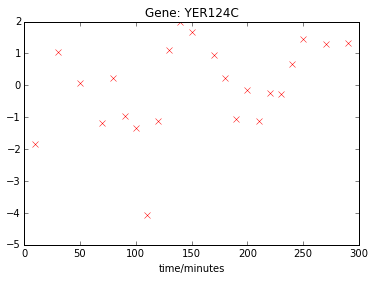

In [34]:
def plot_gene(gene_name='YER124C'):
    plt.plot(data['t'], data['Y'][gene_name], 'rx')
    plt.title('Gene: ' + gene_name)
    plt.xlabel('time/minutes')
plot_gene('YER124C')

Our second data set is from ChiP-chip experiments performed on yeast by [Lee et al (2002)](http://www.cs.gsu.edu/~wkim/index_files/ref/TR.pdf). These give us the binding information between transcription factors and genes. In this notebook we are going to try and combine this binding information with the gene expression information to infer transcription factor activities.

In [35]:
data = GPy.util.datasets.lee_yeast_ChIP()
# set S to find relationships where p-value is less than 1e-3
S = data['Y'].T<1e-3

In [36]:
print Y.shape

(23, 6178)


In [37]:
S.shape

(113, 6270)

More details on the data are give in [this notebook](../datasets/leeYeastChip.ipynb).

### Matching the Data

The two data sets have slightly different overlapping sets of genes. Fortunately, with `pandas` it is easy to do the matching.

In [38]:
intersect = list(set(S.columns) & set(Y.columns))
# this is the new value for n
print 'There are n=', len(intersect), 'overlapping genes.'
# Now reset S and Y to have the overlap of genes
Y = Y[intersect].T # now an n by T matrix
S = S[intersect].T # now an n by q matrix

There are n= 6099 overlapping genes.


### Model for Transcription Factor Activities

We are working with *log* expression levels in a matrix $\mathbf{Y} \in \Re^{n\times T}$ and we will assume a linear (additive) model giving the relationship between the expression level of the gene and the corresponding transcription factor activity which are unobserved, but we represent by a matrix $\mathbf{F} \in \Re^{q\times T}$. Our basic assumption is as follows. Transcription factors are in time series, so they are likely to be temporally smooth. Further we assume that the transcription factors are potentially correlated with one another (to account for transcription factors that operate in unison). 

#### Correlation Between Transcription Factors 
If there are $q$ transcription factors then correlation between different transcription factors is encoded in a covariance matrix, $\boldsymbol{\Sigma}$ which is $q\times q$ in dimensionality. 

#### Temporal Smoothness

Further we assume that the log of the transcription factors' activities is temporally smooth, and drawn from an underlying Gaussian process with covariance $\mathbf{K}_t$. 

#### Intrinsic Coregionalization Model

We assume that the joint process across all $q$ transcription factor activities and across all time points is well represented by an *intrinsic model of coregionalization* where the covariance is given by the Kronecker product of these terms.
$$\mathbf{K}_f = \mathbf{K}_t \otimes \boldsymbol{\Sigma}$$

This is known as an intrinsic coregionalization model [Wackernagel, (2003)](http://books.google.co.uk/books/about/Multivariate_Geostatistics.html?id=Rhr7bgLWxx4C). See [Alvarez et al (2012)](http://www.nowpublishers.com/articles/foundations-and-trends-in-machine-learning/MAL-036) for a machine learning orientated review of these methods. The matrix $\boldsymbol{\Sigma}$ is known as the coregionalization matrix.

### Relation to Gene Expressions

We now assume that the $j$th gene's expression is given by the product of the transcription factors that bind to that gene. Because we are working in log space, that implies a log linear relationship. At the $i$th time point, the log of the $j$th gene's expression, $\mathbf{y}_{:,i}$ is linearly related to the log of the transcription factor activities at the corresponding time point, $\mathbf{f}_{:, i}$. This relationship is given by the binding information from $\mathbf{S}$. We then assume that there is some corrupting Gaussian noise to give us the final observation.

$$\mathbf{y}_{:, i} = \mathbf{S}\mathbf{f}_{:, i} + \boldsymbol{\epsilon}_i$$

where the Gaussian noise is sampled from 

$$\boldsymbol{\epsilon}_i \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}).$$

### Gaussian Process Model of Gene Expression

We consider a vector operator which takes all the separate time series in $\mathbf{Y}$ and stacks the time series to form a new vector $n\times T$ length vector $\mathbf{y}$. A similar operation is applied to form a $q \times T$ length vector $\mathbf{f}$. Using Kronecker products we can now represent the relationship between $\mathbf{y}$ and $\mathbf{f}$ as follows:  
$$
\mathbf{y} = \left[\mathbf{I} \otimes \mathbf{S}\right] \mathbf{f} + \boldsymbol{\epsilon}.
$$
[Standard properties of multivariate Gaussian distributions](../background/gaussianProperties.ipynb) tell us that 

$$\mathbf{y} \sim \mathcal{N}(\mathbf{0}, \mathbf{K}),$$

where
$$
\mathbf{K} = \mathbf{K}_t \otimes \mathbf{S} \boldsymbol{\Sigma} \mathbf{S}^\top + \sigma^2 \mathbf{I}.
$$
and the log likelihood of the model can be written as:
$$
L = -\frac{1}{2} \log |\mathbf{K}| - \frac{1}{2} \mathbf{y}^\top \mathbf{K}^{-1} \mathbf{y}.
$$
The covariance matrix in this log likelihood is of size $n$ by $T$ where $n$ is number of genes and $T$ is number of time points. For many experiments this covariance matrix is prohibitively large. It will require $\mathcal{O}(n^3T^3)$ operations to invert and $\mathcal{O}(n^2T^2)$ storage. We need to look for ways of representing the same covariance with alternative approximations.

In the worst case, because the vector $\mathbf{y}$ contains $T\times n$ points ($T$ time points for each of $n$ genes) we are faced with $O(T^3n^3)$ computational complexity. We are going to use a rotation trick to help. 

### Improving the Computational Complexity

However, we can get a drastic reduction in the size of the covariance function by considering the singular value decomposition of $\mathbf{S}$. 

The matrix $\mathbf{S}$ is $n$ by $q$ matrix, where $q$ is the number of transcription factors. It contains a 1 if a given transcription factor binds to a given gene, and zero otherwise.


####  Rotating the Basis of a Multivariate Gaussian

For any multivariate Gaussian you can rotate the data set and compute a new roated covariance which is valid for the rotated data set. Mathematically this works by first inserting $\mathbf{R}\mathbf{R}^\top$ into the likelihood at three points as follows:

$$L = -\frac{1}{2} \log |\mathbf{K}\mathbf{R}^\top\mathbf{R}| - \frac{1}{2} \mathbf{y}^\top\mathbf{R}^\top\mathbf{R} \mathbf{K}^{-1}\mathbf{R}^\top\mathbf{R} \mathbf{y} + \text{const}$$

The rules of determinants and a transformation of the data allows us to rewrite the likelihood as

$$L = -\frac{1}{2} \log |\mathbf{R}^\top\mathbf{K}\mathbf{R}| - \frac{1}{2} \hat{\mathbf{y}}^\top \left[\mathbf{R}^\top\mathbf{K}\mathbf{R}\right]^{-1}\hat{\mathbf{y}} + \text{const}$$

where we have introduced a rotated version of our data set: $\hat{\mathbf{y}}=\mathbf{R} \mathbf{y}$. Geometrically what this says is that if we want to maintain the same likelihood, then when we rotate our data set by $\mathbf{R}$ we need to rotate either side of the covariance matrix by $\mathbf{R}$, which makes perfect sense when we recall the properties of the multivariate Gaussian. 

#### A Kronecker Rotation

In this notebook we are using a particular structure of covariance which involves a Kronecker product. The rotation we consider will be a Kronecker rotation (see [Stegle et al, 2011](http://papers.nips.cc/paper/4281-efficient-inference-in-matrix-variate-gaussian-models-with-iid-observation-noise.pdf)). We are going to try and take advantage of the fact that the matrix $\mathbf{S}$ is square meaning that $\mathbf{S}\boldsymbol{\Sigma}\mathbf{S}^\top$ is not full rank (it has rank of most $q$, but is size $n\times n$, and we expect number of transcription factors $q$ to be less than number of genes $n$). 

When ranks are involved, it is always a good idea to look at singular value decompositions (SVDs). The SVD of $\mathbf{S}$ is given by:
$$\mathbf{S} = \mathbf{Q} \boldsymbol{\Lambda} \mathbf{V}^\top$$
where $\mathbf{V}^\top \mathbf{V} = \mathbf{I}$, $\boldsymbol{\Lambda}$ is a diagonal matrix of positive values, $\mathbf{Q}$ is a matrix of size $n\times q$: it matches the dimensionality of $\mathbf{S}$, but we have $\mathbf{Q}^\top \mathbf{Q} = \mathbf{I}$. Note that because it is not square, $\mathbf{Q}$ is not in itself a rotation matrix. However it could be seen as the first $q$ columns of an $n$ dimensional rotation matrix (assuming $n$ is larger than $q$, i.e. there are more genes than transcription factors). 

If we call the $n-q$ missing columns of this rotation matrix $\mathbf{U}$ then we have a valid rotation matrix $\mathbf{R}=\begin{bmatrix} \mathbf{Q}& \mathbf{U}\end{bmatrix}$. Although this rotation matrix is only rotating across the $n$ dimensions of the genes, not the additional dimensions across time. In other words we are choosing $\mathbf{K}_t$ to be unrotated. To represent this properly for our covariance we need to set $\mathbf{R} = \mathbf{I} \otimes \begin{bmatrix} \mathbf{Q}& \mathbf{U}\end{bmatrix}$. This gives us a structure that when applied to a covariance of the form $\mathbf{K}_t\otimes \mathbf{K}_n$ it will rotate $\mathbf{K}_n$ whilst leaving $\mathbf{K}_t$ untouched.

When we apply this rotation matrix to $\mathbf{K}$ we have to consider two terms, the rotation of $\mathbf{K}_t \otimes \mathbf{S}\boldsymbol{\Sigma}\mathbf{S}^\top$, and the rotation of $\sigma^2 \mathbf{I}$.

Rotating the latter is easy, because it is just the identity multiplied by a scalar so it remains unchanged
$$
\mathbf{R}^\top\mathbf{I}\sigma^2 \mathbf{R}= \mathbf{I}\sigma^2
$$
The former is slightly more involved, for that term we have
$$
\left[\mathbf{I}\otimes \begin{bmatrix}\mathbf{Q} & \mathbf{U}\end{bmatrix}^\top \right]\mathbf{K}_t \otimes \mathbf{S}\boldsymbol{\Sigma}\mathbf{S}^\top\left[ \mathbf{I} \otimes \begin{bmatrix}\mathbf{Q} & \mathbf{U}\end{bmatrix}\right]=\mathbf{K}_t \otimes \begin{bmatrix}\mathbf{Q} & \mathbf{U}\end{bmatrix}^\top \mathbf{S} \boldsymbol{\Sigma}\mathbf{S}^\top \begin{bmatrix}\mathbf{Q} & \mathbf{U}\end{bmatrix}.
$$ 
Since $\mathbf{S} = \mathbf{Q}\boldsymbol{\Lambda}\mathbf{V}^\top$ then we have
$$
\begin{bmatrix}\mathbf{Q} & \mathbf{U}\end{bmatrix}^\top \mathbf{X}\boldsymbol{\Sigma}\mathbf{X}^\top\begin{bmatrix}\mathbf{Q} & \mathbf{U}\end{bmatrix} = \begin{bmatrix}\boldsymbol{\Lambda} \mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V} \boldsymbol{\Lambda} &\mathbf{0} \\ \mathbf{0} & \mathbf{0}\end{bmatrix}.
$$
This prompts us to split our vector $\hat{\mathbf{y}}$ into a $q$ dimensional vector $\hat{\mathbf{y}}_q =\mathbf{Q}^\top \mathbf{y}$ and an $n-q$ dimensional vector $\hat{\mathbf{y}}_u = \mathbf{U}^\top \mathbf{y}$. The Gaussian likelihood can be written as
$$
L = L_u + L_q + \text{const}
$$
where
$$
L_q = -\frac{1}{2} \log |\mathbf{K}_t\otimes\boldsymbol{\Lambda}\mathbf{V}^\top\boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda}+\sigma^2\mathbf{I}| - \frac{1}{2} \hat{\mathbf{y}}_q^\top \left[\mathbf{K}_t\otimes \boldsymbol{\Lambda}\mathbf{V}^\top\boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda}+\sigma^2\mathbf{I}\right]^{-1} \hat{\mathbf{y}}_q
$$
and
$$
L_u = -\frac{T(n-q)}{2} \log \sigma^2  -\frac{1}{2\sigma^2} \hat{\mathbf{y}}_u^\top \hat{\mathbf{y}}_u
$$
Strictly speaking we should fit these models jointly, but for the purposes of illustration we will firstly use a simple procedure. Firstly, we fit the noise variance $\sigma^2$ on $\hat{\mathbf{y}}_u$ alone using $L_u$. Once this is done, fix the value of $\sigma^2$ in $L_q$ and optimize with respect to the other parameters.

### Inferring the Transcription Factors

The model for $\hat{y}_q$ assumes that we have some latent function $\mathbf{f}$ which is sampled according to the covariance $\mathbf{K}_f = \mathbf{K}_t \otimes \mathbf{\Sigma}$ which is then multiplied by $\mathbf{I}\otimes \mathbf{V}\boldsymbol{\Lambda}$ and corrupted with Gaussian noise. To recover predictions for $\mathbf{f}$ we first define $\mathbf{g} = \mathbf{I}\otimes \mathbf{V}\boldsymbol{\Lambda} \mathbf{f}$, then we have that posterior predictions for $\mathbf{g}$ may be had through,
$$
g|\hat{y} \sim \mathcal{N}(\boldsymbol{\mu}_g, \boldsymbol{\Sigma}_g)
$$
where
$$
\mu_g = \mathbf{K}_*\otimes\boldsymbol{\Lambda}\mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda} \left[\mathbf{K}_t\otimes\boldsymbol{\Lambda}\mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda} + \sigma^2 \mathbf{I}\right]^{-1} \hat{\mathbf{y}}_q
$$
and
$$
\mathbf{C}_g = \mathbf{K}_{*,*}\otimes\boldsymbol{\Lambda}\mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda} - \mathbf{K}_*\otimes\boldsymbol{\Lambda}\mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda} \left[\mathbf{K}_t\otimes\boldsymbol{\Lambda}\mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_*\otimes\boldsymbol{\Lambda}\mathbf{V}^\top \boldsymbol{\Sigma}\mathbf{V}\boldsymbol{\Lambda}
$$
We can then easily find the values for the latent transcription factors,
$$
\mathbf{f} = \mathbf{I}\otimes \mathbf{V}\boldsymbol{\Lambda}^{-1}\mathbf{g} .
$$

In [39]:
# step 1, find the SVD of S.
n, q = S.shape
T = Y.shape[1]
R, Lambda, V = scipy.linalg.svd(S)
# Extract first q columns for Q
Q = R[:, :q]
# remaining columns for U
U = R[:, q:]


In [40]:
S.shape

(6099, 113)

In [41]:
Q.shape
#U.shape
#Y.shape

(6099, 113)

In [42]:
# Find sigma2 by looking at variance of y_u
Y_u = np.dot(U.T, Y)
sigma2 = 1./(T*(n-q))*(Y_u*Y_u).sum()
print "sigma2 found as", sigma2


sigma2 found as 0.178461463478


In [43]:
# Prepare the data for processing in GPy
Y_q = np.dot(Q.T, Y) # project data onto the principal subspace of X 

# Generate the input associated with each Y, the TF and the time point.
x0, x1 = np.asarray(np.meshgrid(t.flatten(),np.arange(q)))
X = np.hstack([x0.flatten()[:, None], x1.flatten()[:, None]])
y = Y_q.flatten()[:, None]

In [50]:

kern = GPy.kern.RBF(1, active_dims=[0])*GPy.kern.Coregionalize(1,q,rank=5, active_dims=[1])
m = GPy.models.GPRegression(X, y, kern)
m.mul.rbf.lengthscale = 50
m.Gaussian_noise.variance = sigma2
#m.Gaussian_noise.variance.constrain_fixed()
#()#kern, t, y_q)
#m.sigma2 = constrained_fixed(sigma2)
#m.optimize(messages=True)

In [53]:
display(m)

GP_regression.,Value,Constraint,Prior,Tied to
mul.rbf.variance,0.00651196130771,+ve,,
mul.rbf.lengthscale,0.00206584508074,+ve,,
mul.coregion.W,"(113, 5)",,,
mul.coregion.kappa,"(113,)",+ve,,
Gaussian_noise.variance,0.0995307944003,+ve,,


In [52]:
_ = m.optimize()
#m.plot(fixed_inputs=[(1, 1)]) # this would plot ACE2.

In [54]:
display(m)

GP_regression.,Value,Constraint,Prior,Tied to
mul.rbf.variance,0.00651196130771,+ve,,
mul.rbf.lengthscale,0.00206584508074,+ve,,
mul.coregion.W,"(113, 5)",,,
mul.coregion.kappa,"(113,)",+ve,,
Gaussian_noise.variance,0.0995307944003,+ve,,


With the current design the model is switching off the temporal correlation. The next step in the analysis will be to reimplement the same model as described by [Sanguinetti et al (2006)](http://bioinformatics.oxfordjournals.org/content/22/14/1753.short) and recover their results. That will involve using an Ornstein Uhlbeck covariance and joint maximisation of the likelihoood of $L_u$ and $L_q$.

Things to do:
1. Code the model such that $L_q$ and $L_u$ are jointly optimized.
2. Recover the true latent functions associated with the transcription factor activities. 
3. Implement the same model with the OU covariance function.

This work is funded by a Commonwealth Scholarship to Arif Rahman and by the EU FP7 RADIANT project.